Tinyml anomaly detection for industrial machines with periodic duty cycles

Code use to develop the models associated with the [paper](https://ieeexplore.ieee.org/abstract/document/10636584/)

![Duty cycles](10636584-fig-1-source-small.gif)

![Pattern recognition](10636584-fig-2-source-small.gif)

In [2]:
import numpy as np
import pandas as pd
import datetime, os
import matplotlib.pyplot as plt
from my_functions import read_month_data , df_timestamps, ndarray_labels, smooth_labels, display_results, report_metrics, display_results_dutycycle

from sklearn import preprocessing
from collections import Counter

from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Data Preparation
## import csv data (speed and pressures)

In [3]:
directory="../../data/"
data_csv_jun21 = read_month_data(directory+'Confidential_Drive_data_Jun2021.csv')
data_csv_okt21 = read_month_data(directory+'Confidential_Drive_data_Okt2021.csv')
data_csv_jan22 = read_month_data(directory+'Confidential_Drive_data_Jan2022.csv')
data_csv_april22 = read_month_data(directory+'Confidential_Drive_data_April2022.csv')

# round to zero speed less than zero
data_csv_jun21.loc[data_csv_jun21['Speed'] < 0 , 'Speed'] = 0
data_csv_okt21.loc[data_csv_okt21['Speed'] < 0 , 'Speed'] = 0
data_csv_jan22.loc[data_csv_jan22['Speed'] < 0 , 'Speed'] = 0
data_csv_april22.loc[data_csv_april22['Speed'] < 0 , 'Speed'] = 0

# complete the dataset with missing values
full_timestamp_01 = pd.date_range(start = data_csv_jun21.index[0], end = data_csv_jun21.index[-1],inclusive="both",freq="1min" )
data_csv_jun21 = data_csv_jun21.reindex(full_timestamp_01)

full_timestamp_02 = pd.date_range(start = data_csv_okt21.index[0], end = data_csv_okt21.index[-1],inclusive="both",freq="1min" )
data_csv_okt21 = data_csv_okt21.reindex(full_timestamp_02)

full_timestamp_03 = pd.date_range(start = data_csv_jan22.index[0], end = data_csv_jan22.index[-1],inclusive="both",freq="1min" )
data_csv_jan22 = data_csv_jan22.reindex(full_timestamp_03)

full_timestamp_04 = pd.date_range(start = data_csv_april22.index[0], end = data_csv_april22.index[-1],inclusive="both",freq="1min" )
data_csv_april22 = data_csv_april22.reindex(full_timestamp_04)

#use linear interpolation for the NaN missing values
data_csv_jun21['Speed']=data_csv_jun21['Speed'].interpolate("linear")
data_csv_jun21['High-pressure']=data_csv_jun21['High-pressure'].interpolate("linear")
data_csv_jun21['Low-pressure']=data_csv_jun21['Low-pressure'].interpolate("linear")

data_csv_okt21['Speed']=data_csv_okt21['Speed'].interpolate("linear")
data_csv_okt21['High-pressure']=data_csv_okt21['High-pressure'].interpolate("linear")
data_csv_okt21['Low-pressure']=data_csv_okt21['Low-pressure'].interpolate("linear")

data_csv_jan22['Speed']=data_csv_jan22['Speed'].interpolate("linear")
data_csv_jan22['High-pressure']=data_csv_jan22['High-pressure'].interpolate("linear")
data_csv_jan22['Low-pressure']=data_csv_jan22['Low-pressure'].interpolate("linear")

data_csv_april22['Speed']=data_csv_april22['Speed'].interpolate("linear")
data_csv_april22['High-pressure']=data_csv_april22['High-pressure'].interpolate("linear")
data_csv_april22['Low-pressure']=data_csv_april22['Low-pressure'].interpolate("linear")


## Compute features

In [7]:
def compute_moving_filter(df1,df2,df3,df4,order):
    df1["Speed_order"+str(order)] = df1['Speed'].rolling(window=order, center=True, min_periods=1).mean()
    df2["Speed_order"+str(order)] = df2['Speed'].rolling(window=order, center=True, min_periods=1).mean()
    df3["Speed_order"+str(order)] = df3['Speed'].rolling(window=order, center=True, min_periods=1).mean()
    df4["Speed_order"+str(order)] = df4['Speed'].rolling(window=order, center=True, min_periods=1).mean()

    df1["High-pressure_order"+str(order)] = df1['High-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df2["High-pressure_order"+str(order)] = df2['High-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df3["High-pressure_order"+str(order)] = df3['High-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df4["High-pressure_order"+str(order)] = df4['High-pressure'].rolling(window=order, center=True, min_periods=1).mean()

    df1["Low-pressure_order"+str(order)] = df1['Low-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df2["Low-pressure_order"+str(order)] = df2['Low-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df3["Low-pressure_order"+str(order)] = df3['Low-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df4["Low-pressure_order"+str(order)] = df4['Low-pressure'].rolling(window=order, center=True, min_periods=1).mean()
    df1['Diff-pressure_order'+str(order)]=df1['High-pressure_order'+str(order)]-df1['Low-pressure_order'+str(order)]
    df2['Diff-pressure_order'+str(order)]=df2['High-pressure_order'+str(order)]-df2['Low-pressure_order'+str(order)]
    df3['Diff-pressure_order'+str(order)]=df3['High-pressure_order'+str(order)]-df3['Low-pressure_order'+str(order)]
    df4['Diff-pressure_order'+str(order)]=df4['High-pressure_order'+str(order)]-df4['Low-pressure_order'+str(order)]


compute_moving_filter(data_csv_jan22,data_csv_okt21,data_csv_jun21,data_csv_april22,order=3)
compute_moving_filter(data_csv_jan22,data_csv_okt21,data_csv_jun21,data_csv_april22,order=5)

# compute the difference between high and low pressure
data_csv_april22['Diff-pressure']=data_csv_april22['High-pressure']-data_csv_april22['Low-pressure']
data_csv_jan22['Diff-pressure']=data_csv_jan22['High-pressure']-data_csv_jan22['Low-pressure']
data_csv_jun21['Diff-pressure']=data_csv_jun21['High-pressure']-data_csv_jun21['Low-pressure']
data_csv_okt21['Diff-pressure']=data_csv_okt21['High-pressure']-data_csv_okt21['Low-pressure']

## Import ground truth labels from Imagimob files

    Import labels of the internal states generated with imagimob

Labels reference:

A: Machine is off

B: Idle. Machine on, but w/o movement and load

C: Belt running w/o load

D: Belt running with load

    Import labels of the duty cyles generated with imagimob

Labels reference:

Cycle: indicate that the machine is used as part of a duty-cycle

In [9]:
#read files from imagimob
directory='../data/'
column_interest=['Time(Seconds)' , 'Length(Seconds)',"Label(string)"]

#read labels of states
file_imagimob_1 = pd.read_csv(directory+"April_2022/Label.label",usecols=column_interest)
file_imagimob_2 = pd.read_csv(directory+"Jan_2022/Label.label",usecols=column_interest)
file_imagimob_3 = pd.read_csv(directory+"Jun_2021/Label.label",usecols=column_interest)
file_imagimob_4 = pd.read_csv(directory+"Okt_2021/Label.label",usecols=column_interest)

timestamps_april2022 = df_timestamps(file_imagimob_1)
timestamps_jan2022 = df_timestamps(file_imagimob_2)
timestamps_jun2021 = df_timestamps(file_imagimob_3)
timestamps_okt2021 = df_timestamps(file_imagimob_4)

#read labels of duty-cycle
file_imagimob_1 = pd.read_csv(directory+"April_2022/Label_cycle.label",usecols=column_interest)
file_imagimob_2 = pd.read_csv(directory+"Jan_2022/Label_cycle.label",usecols=column_interest)
file_imagimob_3 = pd.read_csv(directory+"Jun_2021/Label_cycle.label",usecols=column_interest)
file_imagimob_4 = pd.read_csv(directory+"Okt_2021/Label_cycle.label",usecols=column_interest)

timestamps_cycle_april2022 = df_timestamps(file_imagimob_1)
timestamps_cycle_jan2022 = df_timestamps(file_imagimob_2)
timestamps_cycle_jun2021 = df_timestamps(file_imagimob_3)
timestamps_cycle_okt2021 = df_timestamps(file_imagimob_4)

In [10]:
#generate vector with the labels of reference (states)
downsampled_freq='1T'
true_label_april22 = ndarray_labels(datetime.datetime(2022, 4, 1),datetime.datetime(2022, 5, 1),timestamps_april2022,downsampled_freq)
true_label_jan22 = ndarray_labels(datetime.datetime(2021, 12, 21),datetime.datetime(2022, 1, 21),timestamps_jan2022,downsampled_freq)
true_label_jun21 = ndarray_labels(datetime.datetime(2021, 6, 1),datetime.datetime(2021, 7, 1),timestamps_jun2021,downsampled_freq)
true_label_okt21 = ndarray_labels(datetime.datetime(2021, 10, 1),datetime.datetime(2021, 11, 1),timestamps_okt2021,downsampled_freq)

#generate vector with the labels of reference (duty-cycle)
true_label_cycle_april22 = ndarray_labels(datetime.datetime(2022, 4, 1),datetime.datetime(2022, 5, 1),timestamps_cycle_april2022,downsampled_freq)
true_label_cycle_jan22 = ndarray_labels(datetime.datetime(2021, 12, 21),datetime.datetime(2022, 1, 21),timestamps_cycle_jan2022,downsampled_freq)
true_label_cycle_jun21 = ndarray_labels(datetime.datetime(2021, 6, 1),datetime.datetime(2021, 7, 1),timestamps_cycle_jun2021,downsampled_freq)
true_label_cycle_okt21 = ndarray_labels(datetime.datetime(2021, 10, 1),datetime.datetime(2021, 11, 1),timestamps_cycle_okt2021,downsampled_freq)

true_label_cycle_april22 = np.where(true_label_cycle_april22 == None, 'No_cycle', true_label_cycle_april22)
true_label_cycle_jan22 = np.where(true_label_cycle_jan22 == None, 'No_cycle', true_label_cycle_jan22)
true_label_cycle_jun21 = np.where(true_label_cycle_jun21 == None, 'No_cycle', true_label_cycle_jun21)
true_label_cycle_okt21 = np.where(true_label_cycle_okt21 == None, 'No_cycle', true_label_cycle_okt21)

# Generate ground-truth reference files in a different format for later results comparison

In [ ]:
def create_reference_label_file(filename, df_name):
    if not os.path.exists(filename):
        df_label_states = pd.DataFrame()
        df_label_states["start"] = (df_name["start"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')
        df_label_states["end"] = (df_name["end"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')
        df_label_states["label"] = df_name["label"].copy()
        df_label_states["label"][df_label_states["label"] == 'E'] = 'B'

        df_label_states.to_csv(filename, index=False, sep="\t", header=False)
        print(f"File {filename} created successfully.")
    else:
        print(f"File {filename} already exists. Skipping creation.")
    return

create_reference_label_file("./results/april2022_state.txt",timestamps_april2022)
create_reference_label_file("./results/jan2022_state.txt",timestamps_jan2022)
create_reference_label_file("./results/jun2021_state.txt",timestamps_jun2021)
create_reference_label_file("./results/okt2021_state.txt",timestamps_okt2021)

create_reference_label_file("./results/april2022_cycle.txt",timestamps_cycle_april2022)
create_reference_label_file("./results/jan2022_cycle.txt",timestamps_cycle_jan2022)
create_reference_label_file("./results/jun2021_cycle.txt",timestamps_cycle_jun2021)
create_reference_label_file("./results/okt2021_cycle.txt",timestamps_cycle_okt2021)

File ../results/april2022_state.txt already exists. Skipping creation.
File ../results/jan2022_state.txt already exists. Skipping creation.
File ../results/jun2021_state.txt already exists. Skipping creation.
File ../results/okt2021_state.txt already exists. Skipping creation.
File ../results/april2022_cycle.txt already exists. Skipping creation.
File ../results/jan2022_cycle.txt already exists. Skipping creation.
File ../results/jun2021_cycle.txt already exists. Skipping creation.
File ../results/okt2021_cycle.txt already exists. Skipping creation.


### Data Analysis

Plot the duration of the labels

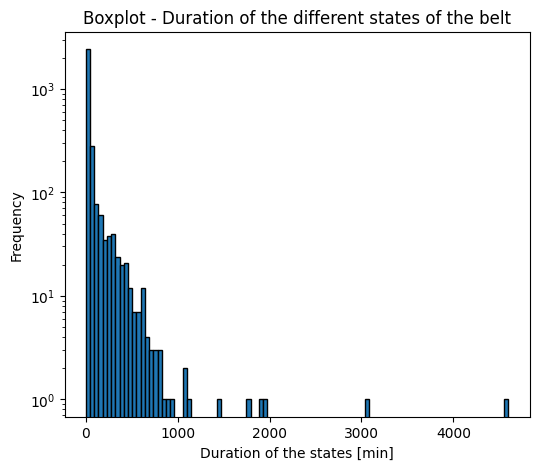

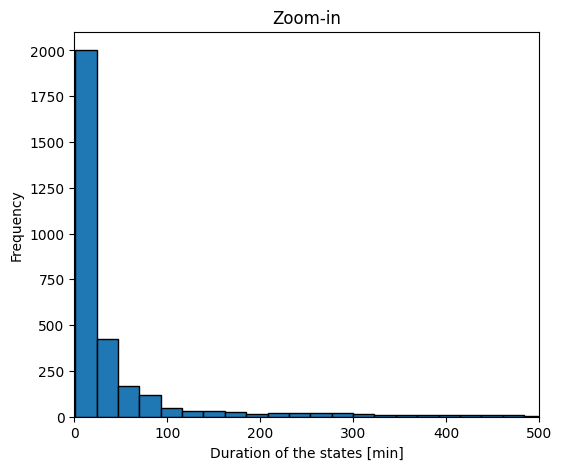

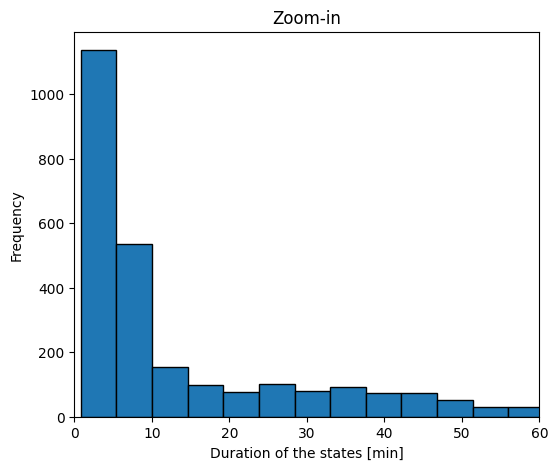

count                         3087
mean     0 days 00:54:50.242630385
std      0 days 02:41:12.930830049
min                0 days 00:00:49
25%                0 days 00:04:06
50%                0 days 00:07:37
75%         0 days 00:39:45.500000
max                3 days 04:38:04
dtype: object


In [15]:

duration_states_april22 = timestamps_april2022["end"] - timestamps_april2022["start"]
duration_states_jan2022 = timestamps_jan2022["end"] - timestamps_jan2022["start"]
duration_states_jun2021 = timestamps_jun2021["end"] - timestamps_jun2021["start"]
duration_states_okt2021 = timestamps_okt2021["end"] - timestamps_okt2021["start"]

duration_states = pd.concat([duration_states_april22, duration_states_jan2022, duration_states_jun2021, duration_states_okt2021])

# Convert timedelta values to total minutes
numeric_values = duration_states.dt.total_seconds()/60

# Plot a boxplot for the numeric values
plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=100, edgecolor='black')
plt.yscale('log')  # Set x-axis scale to logarithmic
plt.title('Boxplot - Duration of the different states of the belt')
plt.xlabel('Duration of the states [min]')
plt.show()

plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=200, edgecolor='black')
plt.title('Zoom-in')
plt.xlabel('Duration of the states [min]')
plt.xlim(0, 500)  # Set x-axis limits
plt.show()

plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=1000, edgecolor='black')
plt.title('Zoom-in')
plt.xlabel('Duration of the states [min]')
plt.xlim(0, 60)  # Set x-axis limits
plt.show()

print(duration_states.describe())

del duration_states_april22, duration_states_jan2022, duration_states_jun2021, duration_states_okt2021
del numeric_values,duration_states

 <i> Conclusions: the minimun duration of a label is 49 sec, i.e., less that the sampled frequency (1-min). Since 25% of the states has a duration of less than 5-min using a downsampling technique to reduce the computation of the data does not look a path to explore. </i>

Plot the duration of the duty-cycles

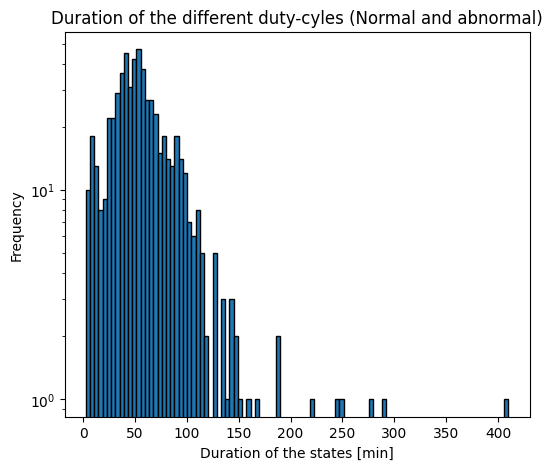

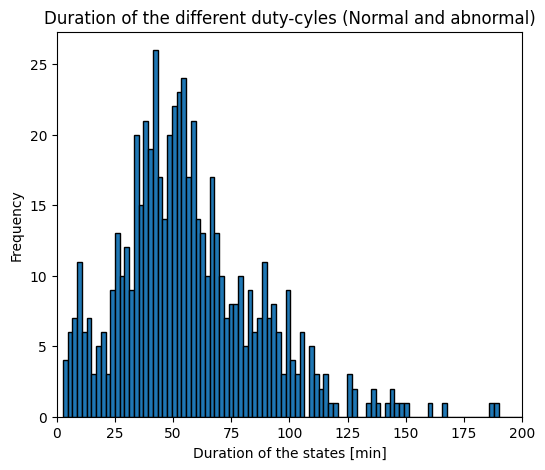

Description of the time between the end and the begin of the next duty-cycles
count                          600
mean     0 days 03:50:33.743333333
std      0 days 09:21:27.446549605
min                0 days 00:00:56
25%         0 days 00:22:56.250000
50%         0 days 02:15:04.500000
75%         0 days 04:59:18.250000
max                8 days 03:14:46
dtype: object


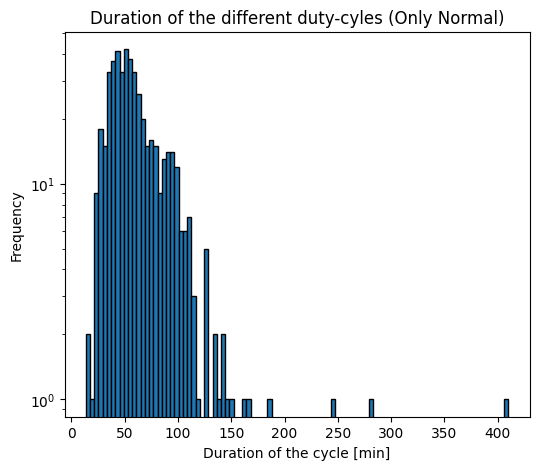

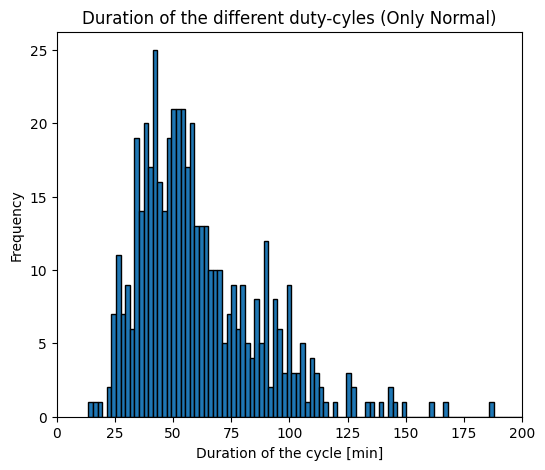

Descrption of normal duty-cycles
count                          497
mean     0 days 01:02:20.503018108
std      0 days 00:33:06.738345763
min                0 days 00:13:31
25%                0 days 00:41:54
50%                0 days 00:54:46
75%                0 days 01:15:50
max                0 days 06:50:04
dtype: object


In [16]:

# Normal and abnormal duty-cycles

duration_cycle_april22 = timestamps_cycle_april2022["end"] - timestamps_cycle_april2022["start"]
duration_cycle_jan2022 = timestamps_cycle_jan2022["end"] - timestamps_cycle_jan2022["start"]
duration_cycle_jun2021 = timestamps_cycle_jun2021["end"] - timestamps_cycle_jun2021["start"]
duration_cycle_okt2021 = timestamps_cycle_okt2021["end"] - timestamps_cycle_okt2021["start"]

duration_cycle = pd.concat([duration_cycle_april22, duration_cycle_jan2022, duration_cycle_jun2021, duration_cycle_okt2021])

# Convert timedelta values to total minutes
numeric_values = duration_cycle.dt.total_seconds()/60

# Plot a boxplot for the numeric values
plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=100, edgecolor='black')
plt.yscale('log')  # Set x-axis scale to logarithmic
plt.title('Duration of the different duty-cyles (Normal and abnormal)')
plt.xlabel('Duration of the states [min]')
plt.show()

plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=200, edgecolor='black')
plt.title('Duration of the different duty-cyles (Normal and abnormal)')
plt.xlabel('Duration of the states [min]')
plt.xlim(0, 200)  # Set x-axis limits
plt.show()

#Time between two consecutive duty-cycles
difference_A = timestamps_cycle_april2022['start'].iloc[1:].reset_index(drop=True) - timestamps_cycle_april2022['end'].iloc[:-1]
difference_B = timestamps_cycle_jan2022['start'].iloc[1:].reset_index(drop=True) - timestamps_cycle_jan2022['end'].iloc[:-1]
difference_C = timestamps_cycle_jun2021['start'].iloc[1:].reset_index(drop=True) - timestamps_cycle_jun2021['end'].iloc[:-1]
difference_D = timestamps_cycle_okt2021['start'].iloc[1:].reset_index(drop=True) - timestamps_cycle_okt2021['end'].iloc[:-1]

time_intra_cycle = pd.concat([difference_A, difference_B, difference_C, difference_D])
numeric_values = time_intra_cycle.dt.total_seconds()/60

print("Description of the time between the end and the begin of the next duty-cycles")
print(time_intra_cycle.describe())

#Only Normal duty-cicles
timestamps_cycle_april2022_filtered=timestamps_cycle_april2022[timestamps_cycle_april2022["label"]=="Normal"]
timestamps_cycle_jan2022_filtered=timestamps_cycle_jan2022[timestamps_cycle_jan2022["label"]=="Normal"]
timestamps_cycle_jun2021_filtered=timestamps_cycle_jun2021[timestamps_cycle_jun2021["label"]=="Normal"]
timestamps_cycle_okt2021_filtered=timestamps_cycle_okt2021[timestamps_cycle_okt2021["label"]=="Normal"]

duration_cycle_april22 = timestamps_cycle_april2022_filtered["end"] - timestamps_cycle_april2022_filtered["start"]
duration_cycle_jan2022 = timestamps_cycle_jan2022_filtered["end"] - timestamps_cycle_jan2022_filtered["start"]
duration_cycle_jun2021 = timestamps_cycle_jun2021_filtered["end"] - timestamps_cycle_jun2021_filtered["start"]
duration_cycle_okt2021 = timestamps_cycle_okt2021_filtered["end"] - timestamps_cycle_okt2021_filtered["start"]

duration_cycle = pd.concat([duration_cycle_april22, duration_cycle_jan2022, duration_cycle_jun2021, duration_cycle_okt2021])

# Convert timedelta values to total minutes
numeric_values = duration_cycle.dt.total_seconds()/60

# Plot a boxplot for the numeric values
plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=100, edgecolor='black')
plt.yscale('log')  # Set x-axis scale to logarithmic
plt.title('Duration of the different duty-cyles (Only Normal)')
plt.xlabel('Duration of the cycle [min]')
plt.show()

plt.figure(figsize=(6, 5))
numeric_values.plot(kind='hist', bins=200, edgecolor='black')
plt.title('Duration of the different duty-cyles (Only Normal)')
plt.xlabel('Duration of the cycle [min]')
plt.xlim(0, 200)  # Set x-axis limits
plt.show()

print("Descrption of normal duty-cycles")
print(duration_cycle.describe())

del timestamps_cycle_april2022_filtered,timestamps_cycle_jan2022_filtered,timestamps_cycle_jun2021_filtered,timestamps_cycle_okt2021_filtered
del duration_cycle_april22, duration_cycle_jan2022, duration_cycle_jun2021, duration_cycle_okt2021, duration_cycle
del difference_A, difference_B, difference_C, difference_D, time_intra_cycle, numeric_values

 <i> Conclusions: the minimun duration of a normal Duty-cycle is 13,5 min, therefore a tolerance of 6.5 min will be used as a collar in the sed_eval toolbox to compare the alignments of the detected and classified duty-cycles. </i>

# Data pre-processing

In [17]:
df_dataset= pd.concat([data_csv_jun21, data_csv_okt21,data_csv_jan22,data_csv_april22])
df_dataset["ref_label"]= np.concatenate((true_label_jun21, true_label_okt21,true_label_jan22,true_label_april22), axis=0)    
df_dataset["ref_label_cycle"]= np.concatenate((true_label_cycle_jun21, true_label_cycle_okt21,true_label_cycle_jan22,true_label_cycle_april22), axis=0)    

removed_indices = df_dataset[df_dataset['ref_label'].isnull()].index.tolist()
df_dataset = df_dataset[df_dataset['ref_label'].notnull()]
df_dataset=df_dataset.reset_index()

x = df_dataset[df_dataset.columns[1:-2]]
y_cycle = df_dataset[df_dataset.columns[-1]]
y_state = df_dataset[df_dataset.columns[-2]]

# normalize feature to range [0;1]
scaler = MinMaxScaler()
scaler.fit(x,4)
x = pd.DataFrame(scaler.transform(x), columns=x.columns)

y_state [y_state=='E']='B'

/tmp/ipykernel_1525396/2856340797.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_state [y_state=='E']='B'


Plot class distribution

Porcentage of non-labelled data: % 3.494911318048314
Original Class=['B'], n=107802 (63.583%)
Original Class=['C'], n=11454 (6.756%)
Original Class=['D'], n=24299 (14.332%)
Original Class=['E'], n=15423 (9.097%)
Original Class=['A'], n=10566 (6.232%)


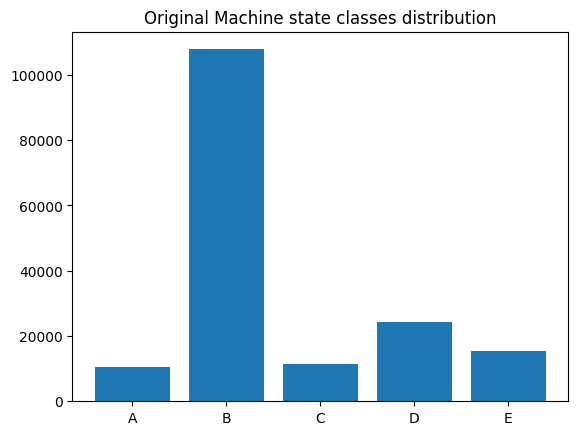

Class=['B'], n=123225 (72.680%)
Class=['C'], n=11454 (6.756%)
Class=['D'], n=24299 (14.332%)
Class=['A'], n=10566 (6.232%)


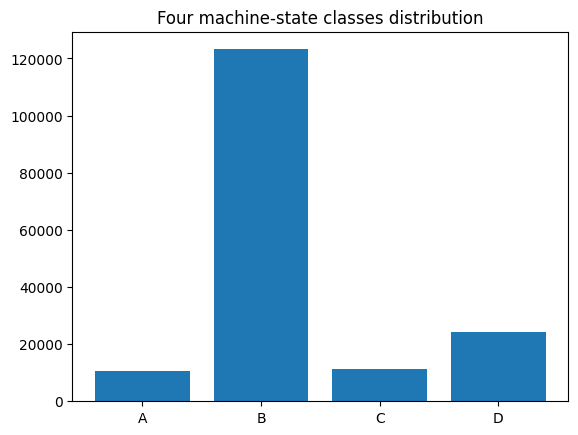

Class=['No_cycle'], n=133926 (78.992%)
Class=['Cycle'], n=35618 (21.008%)


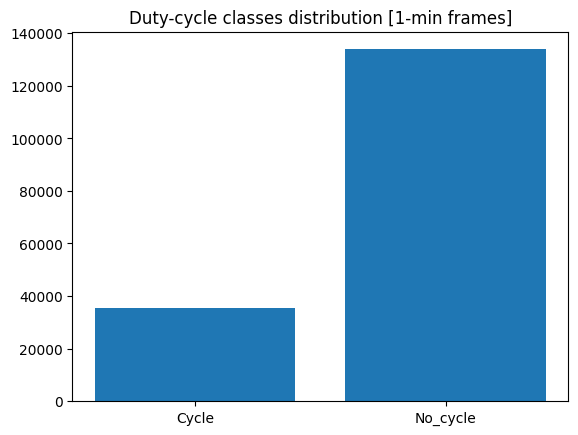

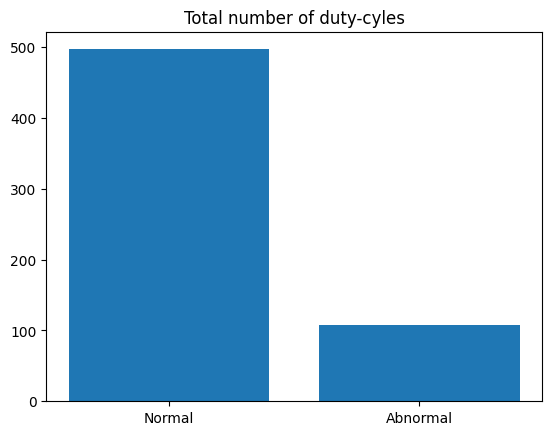

In [18]:
#Analysis data belonging to the different state of the machine
y = np.concatenate((true_label_jun21, true_label_okt21,true_label_jan22,true_label_april22), axis=0)
y2 = np.concatenate((true_label_cycle_jun21, true_label_cycle_okt21,true_label_cycle_jan22,true_label_cycle_april22), axis=0)

print("Porcentage of non-labelled data: %", len(y[y == None])/len(y)*100)

y2 = y2[y != None]
y = y[y != None]

le = preprocessing.LabelEncoder()
le.fit(y)
y_fit=le.transform(y)
counter = Counter(y_fit)
for k,v in counter.items():
	per = v / len(y_fit) * 100
	print('Original Class=%s, n=%d (%.3f%%)' % (le.inverse_transform([k]), v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks(np.arange(len(counter.keys())), le.inverse_transform(np.array(sorted(counter.keys()))) )
plt.title("Original Machine state classes distribution")

plt.show()


y [y=='E']='B'	#Merge two-classes into one

le = preprocessing.LabelEncoder()
le.fit(y)
y_fit=le.transform(y)
counter = Counter(y_fit)
for k,v in counter.items():
	per = v / len(y_fit) * 100
	print('Class=%s, n=%d (%.3f%%)' % (le.inverse_transform([k]), v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.xticks(np.arange(len(counter.keys())), le.inverse_transform(np.array(sorted(counter.keys()))) )
plt.title("Four machine-state classes distribution")

plt.show()


#Analysis data belonging to the duty-cycle
y2 = np.where(y2 == 'Normal', 'Cycle', y2)
y2 = np.where(y2 == 'Abnormal', 'Cycle', y2)

le = preprocessing.LabelEncoder()
le.fit(y2)
y_fit=le.transform(y2)
counter = Counter(y_fit)
for k,v in counter.items():
	per = v / len(y_fit) * 100
	print('Class=%s, n=%d (%.3f%%)' % (le.inverse_transform([k]), v, per))

plt.bar(counter.keys(), counter.values())
plt.xticks(np.arange(len(counter.keys())), le.inverse_transform(np.array(sorted(counter.keys()))) )
plt.title("Duty-cycle classes distribution [1-min frames]")

plt.show()

total_normal_cycles = np.count_nonzero(timestamps_cycle_april2022 == 'Normal') + np.count_nonzero(timestamps_cycle_jan2022 == 'Normal') + np.count_nonzero(timestamps_cycle_jun2021 == 'Normal') + np.count_nonzero(timestamps_cycle_okt2021 == 'Normal')
total_abnormal_cycles = np.count_nonzero(timestamps_cycle_april2022 == 'Abnormal') + np.count_nonzero(timestamps_cycle_jan2022 == 'Abnormal') + np.count_nonzero(timestamps_cycle_jun2021 == 'Abnormal') + np.count_nonzero(timestamps_cycle_okt2021 == 'Abnormal')

plt.bar(["Normal","Abnormal"], [total_normal_cycles,total_abnormal_cycles])
plt.title("Total number of duty-cyles")
plt.show()
del y, y2, v, y_fit, le, k, per, counter

delete not requires variables

In [19]:
del full_timestamp_01,full_timestamp_02,full_timestamp_03,full_timestamp_04
del timestamps_cycle_april2022, timestamps_cycle_jan2022, timestamps_cycle_jun2021, timestamps_cycle_okt2021
del true_label_cycle_jun21, true_label_cycle_okt21,true_label_cycle_jan22,true_label_cycle_april22
del downsampled_freq, timestamps_april2022, timestamps_jan2022, timestamps_jun2021, timestamps_okt2021
del scaler
del file_imagimob_1,file_imagimob_2,file_imagimob_3,file_imagimob_4, column_interest, directory

# Clasification of internal states

In [20]:
def classify_states(classifier,num_trees,hidden_nuerons,learning_rate,x,y_state,df_dataset):
    if classifier=="xgboost":
        classification_multi_default_params = {
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "eta": 0.1,
        "max_depth": None,
        "min_child_weight": 1,
        "subsample": 1.0,
        "colsample_bytree": 1.0,
        "seed":100,
        "n_estimators":num_trees
        }
        clf = xgb.XGBClassifier(**classification_multi_default_params)

    elif classifier=="rf":
        classification_default_params = {
        "random_state":100,
        "criterion": "log_loss",
        "max_features": 0.6,
        "max_depth": None,
        "n_jobs":8,
        "class_weight":{0: 1, 1: 1, 2: 2, 3: 1},
        "n_estimators":num_trees,
        "verbose":0
        }
        clf = RandomForestClassifier(**classification_default_params)

    elif classifier=="dt":
        clf = DecisionTreeClassifier(random_state=100,criterion='log_loss')

    elif classifier=="nb":
        clf = GaussianNB()

    elif classifier=="xtree":
        clf = ExtraTreesClassifier(n_estimators=num_trees,random_state=100)
    elif classifier=="mlp":
        clf = MLPClassifier(random_state=100,
                            hidden_layer_sizes=hidden_nuerons,
                            learning_rate_init=learning_rate)
    else:
        print("clasificador incorrecto")
        return

    skf = StratifiedKFold(n_splits=5)
    # convert string labels to int: 'A'->0 - 'B'->1 - 'C'->2 -'D'->3
    le = preprocessing.LabelEncoder()
    le.fit(y_state)
    y_fit=le.transform(y_state)
    counter = Counter(y_fit)

    df_dataset["recognized_label"] = None

    # Cross-validation loop
    for train_index, test_index in skf.split(x, y_fit):
        x_train_fold, x_test_fold = x.iloc[train_index], x.iloc[test_index]
        y_train_fold, y_test_fold = y_fit[train_index], y_fit[test_index]
        
        #balanced dataset
            # Oversampling
        val_A,val_B,val_C,val_D = np.count_nonzero(y_train_fold == 0) , np.count_nonzero(y_train_fold == 1) , np.count_nonzero(y_train_fold == 2) , np.count_nonzero(y_train_fold == 3)
        add_A , add_B , add_C , add_D = round(val_A*1) , 0 , round(val_C*1) , round(val_D*0.0)
        strategy = {0:val_A+add_A, 1:val_B+add_B, 2:val_C+add_C, 3:val_D+add_D}
        oversample = SMOTE(sampling_strategy=strategy,k_neighbors=5,random_state=100)
        X_res, y_res = oversample.fit_resample(x_train_fold, y_train_fold)
            # Undersampling
        val_A,val_B,val_C,val_D = np.count_nonzero(y_res == 0) , np.count_nonzero(y_res == 1) , np.count_nonzero(y_res == 2) , np.count_nonzero(y_res == 3)
        del_A , del_B , del_C , del_D = 0 , round(val_B*0.75) , 0 , 0
        strategy = {0:val_A-del_A, 1:val_B-del_B, 2:val_C-del_C, 3:val_D-del_D}
        undersample = RandomUnderSampler(sampling_strategy=strategy,random_state=100)
        X_train_balanced, y_train_balanced = undersample.fit_resample(X_res, y_res)

        #Train classifier
        clf.fit(X_train_balanced, y_train_balanced)

        y_predict = clf.predict(x_test_fold)

        df_dataset.loc[test_index,"recognized_label"] = le.inverse_transform(y_predict.astype(int))
        
    # Print balanced dataset
    # unique_values, counts = np.unique(y_fit, return_counts=True)
    # value_counts = dict(zip(unique_values, counts))
    # print("Value class-counts in Unbalanced dataset:",value_counts)
    # unique_values, counts = np.unique(y_train_balanced, return_counts=True)
    # value_counts = dict(zip(unique_values, counts))
    # print("Value class-counts in Balanced dataset:",value_counts)

    y_pred = df_dataset["recognized_label"]
    y_pred.dropna(inplace=True)
    display_results(y_state,y_pred,classifier)

    return clf

Select the name of the classifier and the hyper-parameters to evaluate

Balanced Accuracy: 0.9724 - Macro F1-Score: 0.9672


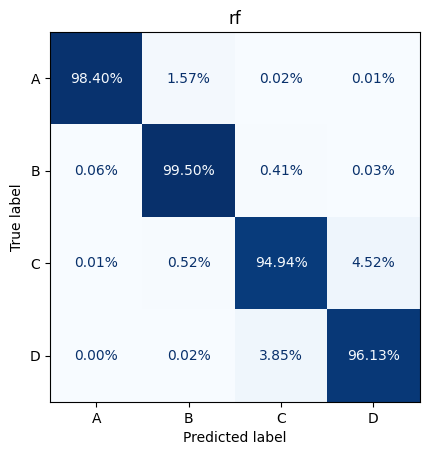

In [21]:
classifier = "rf"   #select 'xgboost' - 'rf' - 'dt' - 'nb' - 'xtree' - 'mlp'

num_trees = 25  #used in ensembled trees. Select 10, 25
hidden_neurons = 12 #used in MLP. Select between 4 and 15
learning_rate = 0.01    # #used in MLP. Select between 0.1, 0.01 or 0.001

clf = classify_states(classifier,num_trees,hidden_neurons,learning_rate,x,y_state,df_dataset)

### Median filter over ML output

In [22]:
filters=[3,5,7,9,11,13,15,17]
y_pred = df_dataset["recognized_label"]
le = preprocessing.LabelEncoder()
le.fit(y_state)

for i in filters:
    print("filter order: ", i)
    y_pred_smoothed = smooth_labels(le.transform(y_pred),i)
    report_metrics(y_state,y_pred_smoothed)


filter order:  3
Balanced Accuracy: 0.9732 - Macro F1-Score: 0.9679
filter order:  5
Balanced Accuracy: 0.9732 - Macro F1-Score: 0.9679
filter order:  7
Balanced Accuracy: 0.9731 - Macro F1-Score: 0.9677
filter order:  9
Balanced Accuracy: 0.9728 - Macro F1-Score: 0.9670
filter order:  11
Balanced Accuracy: 0.9723 - Macro F1-Score: 0.9658
filter order:  13
Balanced Accuracy: 0.9720 - Macro F1-Score: 0.9648
filter order:  15
Balanced Accuracy: 0.9716 - Macro F1-Score: 0.9636
filter order:  17
Balanced Accuracy: 0.9712 - Macro F1-Score: 0.9628


The best result depend of the specific ML classifier. I select the best option for the next steps

Balanced Accuracy: 0.9732 - Macro F1-Score: 0.9679


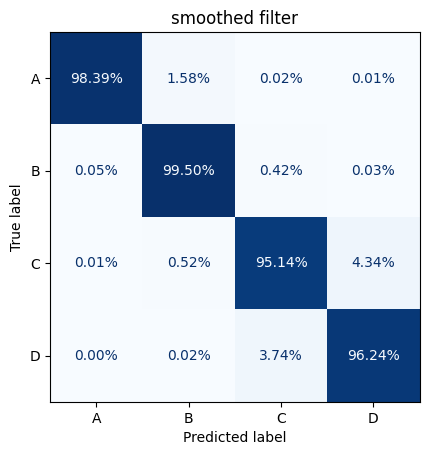

In [23]:
y_pred_smoothed = smooth_labels(le.transform(y_pred),3)
df_dataset['recognized_label'] = le.inverse_transform(y_pred_smoothed)

display_results(y_state,le.inverse_transform(y_pred_smoothed),"smoothed filter")

### convert model to C code

In [ ]:
flag_convert_c_code = False  #set to True if you want to convert the model to C code. The C code is saved in the results folder.

'''
There are a problem between the emlearn and sklearn packages. The problem arise when using the MLP of sklearn.
The easy way to solve is to import emlearn after use the MLP classifier.
However, when imported, then re-run the previous code may generate errors. In that case, the best is to restart the notebook.
'''

if flag_convert_c_code:

    import emlearn
    
    le = preprocessing.LabelEncoder()
    le.fit(y_state)
    y_fit=le.transform(y_state)

    #select the name of the model to save
    if classifier == "nb":
        model_name = './results/nb_model.h'
    elif classifier == "xtree":
        model_name = './results/xtree'+str(num_trees)+'_model.h'
    elif classifier == "mlp":
        model_name = './results/mlp_'+str(hidden_neurons)+'neurons_model.h'
    elif classifier == "rf":
        model_name = './results/rf'+str(num_trees)+'_model.h'
    elif classifier == "dt":
        model_name = './results/dt_model.h'
    elif classifier == "xgboost":
        model_name = './results/xgb'+str(num_trees)+'_model.h'


#some models are constructed with the emlearn toolbox. Others use the micromlgen toolbox
    if classifier in ["nb", "xtree", "mlp"]:
        import emlearn
        cmodel = emlearn.convert(clf)
        cmodel.save(file= model_name, name='model')
    else:
        from micromlgen import port

        with open(model_name, 'w') as file:
            file.write(port(clf, classmap={
                0: 'high_pressure',
                1: 'low_pressure',
                2: 'speed',
                3: 'speed3',
                4: 'high_pressure3',
                5: 'low_pressure3',
                6: 'diff_pressure3',
                7: 'speed5',
                8: 'high_pressure5',
                9: 'low_pressure5',
                10: 'diff_pressure5',
                11: 'diff_pressure'
        }))

# Clasification of duty-cycles using pattern matching
Generate the files with the sequence of recognized states labels 

In [ ]:
def create_segments_state(start_date,end_date):
    complete_range = pd.date_range(start=start_date, end=end_date, freq='1min')
    complete_df = pd.DataFrame({'index': complete_range})

    filtered_df = df_dataset[(df_dataset['index'] >= start_date) & (df_dataset['index'] <= end_date)]

    merged_df = pd.merge(complete_df, filtered_df, on='index', how='left')

    #Compute the start and end of each state
    merged_df['group'] = (merged_df['recognized_label'] != merged_df['recognized_label'].shift()).cumsum()

    dfs = []

    for group_name, group_data in merged_df.groupby('group'):
        label = group_data["recognized_label"].iloc[0]
        if (label != None):
            start = group_data["index"].iloc[0]
            finish = group_data["index"].iloc[-1]
            data_to_append = {'start': start, 'end': finish, 'label': label}
            df = pd.DataFrame(data_to_append,index=[group_name])
            dfs.append(df)

    df_recognized_states = pd.concat(dfs, ignore_index=True)
    return df_recognized_states


# Function to find the indices of the sequence of normal cycle
def find_normal_sequence_indices(df, sequence):
    indices = []
    for i in range(len(df) - len(sequence) + 1):
        if list(df['label'].iloc[i:i+len(sequence)]) == list(sequence):
            indices.append((i, i+len(sequence)-1))
    return indices

#gived a list of index, the function generate abnormal duty-cycle
def generate_abnormal_cycle(start_index, finish_index):
    segments_boundaries = []
    active_segment = None
    
    # Iterate over the start indexes
    for start in start_index:
        # Find the first finish index greater than or equal to the start index
        finish_candidates = [finish for finish in finish_index if finish >= start]
        
        if finish_candidates:
            # Choose the closest finish index to the start index
            finish = min(finish_candidates)
            if active_segment is None:
                active_segment = (start, finish)
            elif finish <= active_segment[1]:
                active_segment = (active_segment[0], max(active_segment[1], finish))
            else:
                segments_boundaries.append(active_segment)
                active_segment = (start, finish)
    if active_segment is not None:
        segments_boundaries.append(active_segment)
    return segments_boundaries


def create_segments_cycles(df_recognized_states):
    # Define the normal and abnormal sequences
    normal_sequences = ["BCDCB", "BCDB"]

    # Find indices for normal sequences
    normal_indices = []
    for sequence in normal_sequences:
        normal_indices.extend(find_normal_sequence_indices(df_recognized_states, sequence))

    # find the begin and end of the abnormal cycles
    abnormal_idx_start = []
    df_recognized_states = df_recognized_states.where(pd.notna(df_recognized_states), None)

    for i in range(len(df_recognized_states)-1):
        if df_recognized_states['label'].iloc[i] == 'B' and df_recognized_states['label'].iloc[i+1] == 'C':
            if not any(start <= i < end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        elif df_recognized_states['label'].iloc[i] == 'B' and df_recognized_states['label'].iloc[i+1] == 'D':
            if not any(start <= i < end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        elif df_recognized_states['label'].iloc[i] == 'A' and df_recognized_states['label'].iloc[i+1] == 'C':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        elif df_recognized_states['label'].iloc[i] == 'A' and df_recognized_states['label'].iloc[i+1] == 'D':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        if df_recognized_states['label'].iloc[i] == None and df_recognized_states['label'].iloc[i+1] == 'C':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        elif df_recognized_states['label'].iloc[i] == None and df_recognized_states['label'].iloc[i+1] == 'D':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        elif df_recognized_states['label'].iloc[i] == None and df_recognized_states['label'].iloc[i+1] == 'C':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_start.append(i)
        elif df_recognized_states['label'].iloc[i] == None and df_recognized_states['label'].iloc[i+1] == 'D':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_start.append(i)

    abnormal_idx_end = []
    for i in range(len(df_recognized_states)-1):
        if df_recognized_states['label'].iloc[i] == 'C' and df_recognized_states['label'].iloc[i+1] == 'B':
            if not any(start < i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'D' and df_recognized_states['label'].iloc[i+1] == 'B':
            if not any(start < i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'C' and df_recognized_states['label'].iloc[i+1] == 'A':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'D' and df_recognized_states['label'].iloc[i+1] == 'A':
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'C' and df_recognized_states['label'].iloc[i+1] == None:
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'D' and df_recognized_states['label'].iloc[i+1] == None:
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'C' and df_recognized_states['label'].iloc[i+1] == None:
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)
        elif df_recognized_states['label'].iloc[i] == 'D' and df_recognized_states['label'].iloc[i+1] == None:
            if not any(start <= i <= end for start, end in normal_indices):
                abnormal_idx_end.append(i)


    abnormal_cycles_idx = generate_abnormal_cycle(abnormal_idx_start, abnormal_idx_end)

    dfs=[]
    for i in range(0,len(normal_indices)):
        start = df_recognized_states.iloc[normal_indices[i][0]+1,0]
        end = df_recognized_states.iloc[normal_indices[i][1]-1,1]
        data_to_append = {'start': start, 'end': end, 'label': "Normal"}
        df = pd.DataFrame(data_to_append,index=[i])
        dfs.append(df)

    for i in range(0,len(abnormal_cycles_idx)):
        start = df_recognized_states.iloc[abnormal_cycles_idx[i][0]+1,0]
        end = df_recognized_states.iloc[abnormal_cycles_idx[i][1],1]
        data_to_append = {'start': start, 'end': end, 'label': "Abnormal"}
        df = pd.DataFrame(data_to_append,index=[i])
        dfs.append(df)

    df_recognized_cycles = pd.concat(dfs, ignore_index=True)
    
    df_recognized_cycles.sort_values(by='start',inplace=True)
    return df_recognized_cycles

In [ ]:
#convert the classified states of 1-min duration in segments
df_recognized_states_april22 = create_segments_state(datetime.datetime(2022, 4, 1),datetime.datetime(2022, 5, 1))
df_recognized_states_jan22 = create_segments_state(datetime.datetime(2021, 12, 21),datetime.datetime(2022, 1, 21))
df_recognized_states_jun21 = create_segments_state(datetime.datetime(2021, 6, 1),datetime.datetime(2021, 7, 1))
df_recognized_states_okt21 = create_segments_state(datetime.datetime(2021, 10, 1),datetime.datetime(2021, 11, 1))



#Use pattern matching to classify the duty-cycles as normal or abnommal
df_recognized_cycles_april22 = create_segments_cycles(df_recognized_states_april22)
df_recognized_cycles_jan22 = create_segments_cycles(df_recognized_states_jan22)
df_recognized_cycles_jun21 = create_segments_cycles(df_recognized_states_jun21)
df_recognized_cycles_okt21 = create_segments_cycles(df_recognized_states_okt21)

# save the results in files
create_reference_label_file("./results/recognized/april2022_state.txt",df_recognized_states_april22)
create_reference_label_file("./results/recognized/jan2022_state.txt",df_recognized_states_jan22)
create_reference_label_file("./results/recognized/jun2021_state.txt",df_recognized_states_jun21)
create_reference_label_file("./results/recognized/okt2021_state.txt",df_recognized_states_okt21)

create_reference_label_file("./results/recognized/april2022_cycle.txt",df_recognized_cycles_april22)
create_reference_label_file("./results/recognized/jan2022_cycle.txt",df_recognized_cycles_jan22)
create_reference_label_file("./results/recognized/jun2021_cycle.txt",df_recognized_cycles_jun21)
create_reference_label_file("./results/recognized/okt2021_cycle.txt",df_recognized_cycles_okt21)

File ../results/recognized/april2022_state.txt already exists. Skipping creation.
File ../results/recognized/jan2022_state.txt already exists. Skipping creation.
File ../results/recognized/jun2021_state.txt already exists. Skipping creation.
File ../results/recognized/okt2021_state.txt already exists. Skipping creation.
File ../results/recognized/april2022_cycle.txt already exists. Skipping creation.
File ../results/recognized/jan2022_cycle.txt already exists. Skipping creation.
File ../results/recognized/jun2021_cycle.txt already exists. Skipping creation.
File ../results/recognized/okt2021_cycle.txt already exists. Skipping creation.


## Performance evaluation

Evaluation of the duty-cycle classification at level of 1-min frames

Balanced Accuracy: 0.9448 - Macro F1-Score: 0.9103


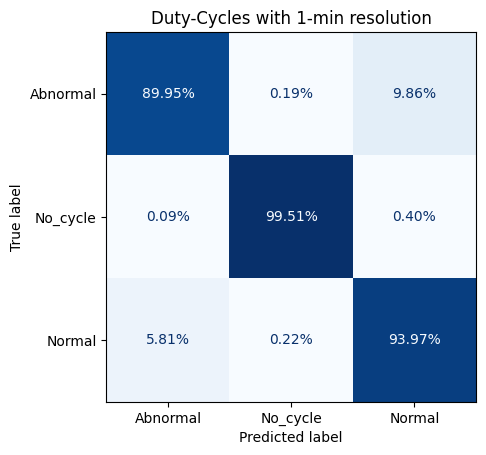

In [ ]:
downsampled_freq='1T'

recognized_label_cycle_april22 = ndarray_labels(datetime.datetime(2022, 4, 1),datetime.datetime(2022, 5, 1),df_recognized_cycles_april22,downsampled_freq)
recognized_label_cycle_jan22 = ndarray_labels(datetime.datetime(2021, 12, 21),datetime.datetime(2022, 1, 21),df_recognized_cycles_jan22,downsampled_freq)
recognized_label_cycle_jun21 = ndarray_labels(datetime.datetime(2021, 6, 1),datetime.datetime(2021, 7, 1),df_recognized_cycles_jun21,downsampled_freq)
recognized_label_cycle_okt21 = ndarray_labels(datetime.datetime(2021, 10, 1),datetime.datetime(2021, 11, 1),df_recognized_cycles_okt21,downsampled_freq)

recognized_label_cycle_april22 = np.where(recognized_label_cycle_april22 == None, 'No_cycle', recognized_label_cycle_april22)
recognized_label_cycle_jan22 = np.where(recognized_label_cycle_jan22 == None, 'No_cycle', recognized_label_cycle_jan22)
recognized_label_cycle_jun21 = np.where(recognized_label_cycle_jun21 == None, 'No_cycle', recognized_label_cycle_jun21)
recognized_label_cycle_okt21 = np.where(recognized_label_cycle_okt21 == None, 'No_cycle', recognized_label_cycle_okt21)

df_aux1 = pd.DataFrame(index=pd.date_range(start=datetime.datetime(2021, 6, 1), end=datetime.datetime(2021, 7, 1), freq='1min'))
df_aux1["data"]=recognized_label_cycle_jun21

df_aux2 = pd.DataFrame(index=pd.date_range(start=datetime.datetime(2021, 10, 1), end=datetime.datetime(2021, 11, 1), freq='1min'))
df_aux2["data"]=recognized_label_cycle_okt21

df_aux3 = pd.DataFrame(index=pd.date_range(start=datetime.datetime(2021, 12, 21), end=datetime.datetime(2022, 1, 21), freq='1min'))
df_aux3["data"]=recognized_label_cycle_jan22

df_aux4 = pd.DataFrame(index=pd.date_range(start=datetime.datetime(2022, 4, 1), end=datetime.datetime(2022, 5, 1), freq='1min'))
df_aux4["data"]=recognized_label_cycle_april22

df_aux = pd.concat([df_aux1,df_aux2,df_aux3,df_aux4])

df_aux.drop(removed_indices,inplace=True)
df_aux=df_aux.reset_index(drop=True)
df_dataset["classified_cycle"] = df_aux["data"]

y_pred = df_dataset["classified_cycle"]
y_true = df_dataset["ref_label_cycle"]
display_results_dutycycle(y_true, y_pred,"Duty-Cycles with 1-min resolution")

Evaluation of the performance using the sed_eval package

![alt text](10636584-fig-3-source-small.gif)

In [1]:
import sed_eval
import dcase_util
import tempfile

In [ ]:
def plot_classification(reference_path,result_path,collar):
    classes = ['Normal', 'Abnormal']


    # Create a temporary folder to save the replaced labels of the prediction of the algorithms.
    temp_dir = tempfile.mkdtemp()
    filenames = os.listdir(reference_path)

    filenames = [file for file in filenames if file.endswith("_cycle.txt")]


    for file in filenames:
        result_file=os.path.join(result_path, file)
        df = pd.read_csv(result_file,sep="\t",names=["Start","Finish","Label"])
        # replace_labels(df)
        temp_file = os.path.join(temp_dir, file)
        df.to_csv(temp_file,index=False,sep="\t",header=False)
        df.head()

    file_list = []

    for file in filenames:
        file_list.append({
            'reference_file': os.path.join(reference_path, file),
            'estimated_file': os.path.join(temp_dir, file)
        })

    data = []

    # Get used event labels
    all_data = dcase_util.containers.MetaDataContainer()
    for file_pair in file_list:
        reference_event_list = sed_eval.io.load_event_list(
            filename=file_pair['reference_file']
        )
        estimated_event_list = sed_eval.io.load_event_list(
            filename=file_pair['estimated_file']
        )

        data.append({'reference_event_list': reference_event_list,
                        'estimated_event_list': estimated_event_list})

        all_data += reference_event_list

    # Start evaluating

        # Create metrics classes, define parameters
        segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
            event_label_list=classes,
            time_resolution=1.0
        )

        event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
            event_label_list=classes,
            t_collar=collar
        )

        # Go through files
        for file_pair in data:
            event_based_metrics.evaluate(
                reference_event_list=file_pair['reference_event_list'],
                estimated_event_list=file_pair['estimated_event_list']
            )

    # Get only certain metrics
    print(event_based_metrics.result_report_class_wise_average())
    print(event_based_metrics.result_report_class_wise())

    # Delete the temporary folder and all its files
    if os.path.exists(temp_dir):
        for root, dirs, files in os.walk(temp_dir, topdown=False):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.rmdir(dir_path)
        os.rmdir(temp_dir)

    # return event_based_metrics.results()["overall"]["f_measure"]["f_measure"]
    return event_based_metrics.results()

def replace_detection_labels(df_senial):
   df_senial["Label"].replace("Normal","Cycle",inplace=True)
   df_senial["Label"].replace("Abnormal","Cycle",inplace=True)
   return df_senial
    

def plot_detection(reference_path,result_path,collar):
    classes = ['Cycle']
    # Create a temporary folder to save the replaced labels of the prediction of the algorithms.
    temp_dir_reference = tempfile.mkdtemp()
    filenames = os.listdir(reference_path)
    filenames = [file for file in filenames if file.endswith("_cycle.txt")]

    for file in filenames:
        result_file=os.path.join(reference_path, file)
        df = pd.read_csv(result_file,sep="\t",names=["Start","Finish","Label"])
        replace_detection_labels(df)
        temp_file = os.path.join(temp_dir_reference, file)
        df.to_csv(temp_file,index=False,sep="\t",header=False)


    # Create a temporary folder to save the replaced labels of the prediction of the algorithms.

    temp_dir_result = tempfile.mkdtemp()

    filenames = [file for file in filenames if file.endswith("_cycle.txt")]


    for file in filenames:
        result_file=os.path.join(result_path, file)
        df = pd.read_csv(result_file,sep="\t",names=["Start","Finish","Label"])
        replace_detection_labels(df)
        temp_file = os.path.join(temp_dir_result, file)
        df.to_csv(temp_file,index=False,sep="\t",header=False)
        # df.head()

    file_list = []

    for file in filenames:
        file_list.append({
            'reference_file': os.path.join(temp_dir_reference, file),
            'estimated_file': os.path.join(temp_dir_result, file)
        })

    data = []

    # Get used event labels
    all_data = dcase_util.containers.MetaDataContainer()
    for file_pair in file_list:
        reference_event_list = sed_eval.io.load_event_list(
            filename=file_pair['reference_file']
        )
        estimated_event_list = sed_eval.io.load_event_list(
            filename=file_pair['estimated_file']
        )

        data.append({'reference_event_list': reference_event_list,
                        'estimated_event_list': estimated_event_list})

        all_data += reference_event_list

    # Start evaluating

        # Create metrics classes, define parameters
        segment_based_metrics = sed_eval.sound_event.SegmentBasedMetrics(
            event_label_list=classes,
            time_resolution=1.0
        )

        event_based_metrics = sed_eval.sound_event.EventBasedMetrics(
            event_label_list=classes,
            t_collar=collar
            # t_collar=1000.0
        )

        # Go through files
        for file_pair in data:
            event_based_metrics.evaluate(
                reference_event_list=file_pair['reference_event_list'],
                estimated_event_list=file_pair['estimated_event_list']
            )


    # Delete the temporary folder and all its files
    if os.path.exists(temp_dir_reference):
        for root, dirs, files in os.walk(temp_dir_reference, topdown=False):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.rmdir(dir_path)
        os.rmdir(temp_dir_reference)

        # Delete the temporary folder and all its files
    if os.path.exists(temp_dir_result):
        for root, dirs, files in os.walk(temp_dir_result, topdown=False):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                os.rmdir(dir_path)
        os.rmdir(temp_dir_result)

    print(event_based_metrics.result_report_class_wise())

    return event_based_metrics.results()["overall"]["f_measure"]["f_measure"]

In [ ]:
reference_path = './results/'
result_path = reference_path + 'recognized'

collar = 202.75
# print("micro F1-score classification: {:.2f}".format(plot_classification(reference_path,result_path,collar)*100))
plot_classification(reference_path,result_path,collar)

print("micro F1-score detection: {:.2f}".format(plot_detection(reference_path,result_path,collar)*100))

  Class-wise average metrics (macro-average)
  F-measure
    F-measure (F1)                  : 85.26 %
    Precision                       : 87.75 %
    Recall                          : 83.03 %
  Error rate
    Error rate (ER)                 : 0.28 
    Deletion rate                   : 0.17 
    Insertion rate                  : 0.11 
  

  Class-wise metrics
    Event label  | Nref    Nsys  | F        Pre      Rec    | ER       Del      Ins    |
    ------------ | -----   ----- | ------   ------   ------ | ------   ------   ------ |
    Normal       | 496     493   | 96.3%    96.6%    96.0%  | 0.07     0.04     0.03   |
    Abnormal     | 107     95    | 74.3%    78.9%    70.1%  | 0.49     0.30     0.19   |

  Class-wise metrics
    Event label  | Nref    Nsys  | F        Pre      Rec    | ER       Del      Ins    |
    ------------ | -----   ----- | ------   ------   ------ | ------   ------   ------ |
    Cycle        | 603     588   | 96.7%    98.0%    95.5%  | 0.06     0.04    

--------------------------------------

Generate a csv file of example with the values of a complete duty-cycle.

The input file values can be assigned to a variable in the C-code for debugging.

In [ ]:
subset_df = df_dataset.iloc[609:724, 1:4]
subset_df.to_csv('./input_data.csv', index=False)